# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np

real_estate_ads = pd.read_csv('real_estate_data.csv', sep='\t')
real_estate_ads.info()
real_estate_ads.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

Объявления о продаже квартир в Санкт-Петербурге. 23699 объявлений и 22 столбца или параметра (1 из них это цена). Большинство столбцов имеют тип данных <b>'float64'</b>. Присутствуют пропущенные значения в нескольких столбцах. Также присутcтвуют категориальные значения в столбце <b>'locality_name'</b> и <b>'is_apartment'</b>. При этом столбец <b>'is_apartment'</b> содержит булевы значения, но они определены как тип <b>'object'</b>, исправим это. Также столбец <b>'first_day_exposition'</b> необходимо обработать таким образом, чтобы он содержал тип данных 'date'. На первый взгляд данные вполне логично и понятны, посмотрим, что будет возникать по мере их исследования.

## Предобработка данных

Как нам показал метод <b>info()</b>, в большинстве столбцов имеются <b>пропущенные значения</b>. Создадим и выведем на экран объект <b>Series</b>, в котором содержится название столбца с пропущенными значениями и их количество.

In [176]:
miss_cols = pd.Series(dtype='float64')
for col in real_estate_ads:
    if real_estate_ads[col].isnull().any() == True:
        miss_cols[col] = real_estate_ads[col].isna().sum()
print(miss_cols.sort_values(ascending=False))

is_apartment           20924
parks_nearest          15620
ponds_nearest          14589
balcony                11519
ceiling_height          9195
airports_nearest        5542
cityCenters_nearest     5519
parks_around3000        5518
ponds_around3000        5518
days_exposition         3181
kitchen_area            2278
living_area             1903
floors_total              86
locality_name             49
dtype: int64


### Столбец 'is_apartment'

Начнем по порядку. Первое место по пропускам занимает столбец <b>'is_apartment'</b> — апартаменты (булев тип). Данный столбец указывает на тип жилого помещения. Рассмотрим какие значения, помимо пропущенных, имеет этот столбец.

In [177]:
real_estate_ads['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

В данном случае все становится ясно, этот столбец содержит <b>булевы значения</b>. False - квартира (не апартаменты), True - апартаменты. Очевидно, если значение пропущено, это означает, что жилое помещение, по которому создано объявление, не является апартаментами (False). 

<b>Для этого столбца заполним пропущенные значения 'False'</b>

#### Замена пропущенных значений

In [178]:
real_estate_ads['is_apartment'] = real_estate_ads['is_apartment'].fillna(False)
# Проведем проверку значений в столбце после замены.
print(real_estate_ads['is_apartment'].value_counts())

False    23649
True        50
Name: is_apartment, dtype: int64


#### Вывод и причины возникновения

Оказывается, среди всех объявлений, лишь <b>0.2%</b> жилых помещений являются апартаментами. Это достаточно мало, но все равно не стоит забывать про данный параметр.

<b>Причиной</b> возникновения пропущенных значений в данном столбце может являться:
- Продавец не указал этот параметр, потому что, как показывает практика, большинство жилых помещений не являются апартаментами, а являются квартирами, соответственно, продавец не счел нужным указывать данный параметр.

### Столбцы 'parks_nearest', 'parks_around3000', 'ponds_nearest', 'ponds_around3000', 'airports_nearest', 'cityCenters_nearest' - картографические данные

#### Замена пропущенных значений

Все перечисленные столбцы относятся к автоматически взятым на основе картографических данных. Заметим, что число пропущенных значений в этих столбцах практически совпадает (за исключением 'parks_nearest' и 'ponds_nearest', здесь есть еще дополнительные сложности).

<b>Заменить данные пропущенные значения не является возможным, так как, если мы заменим их средним числом, то исказим реальность, и у нас получится так, что, например, квартира в двух разных населенных пунктах имеет одинаковое расстояние до Аэропорта (который в Питере всего один).</b>

<b>Считаю правильным ОСТАВИТЬ данные, в которых не достает картографических сведений, ведь эти пропущенные значения имеют смысл, а также мы не можем их восстановить.</b>

#### Вывод и причины возникновения

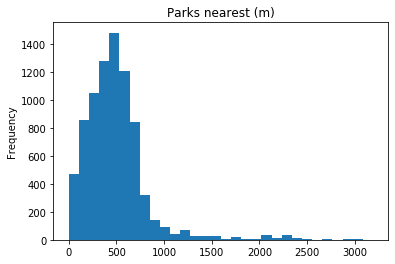

In [179]:
real_estate_ads['parks_nearest'].plot(kind='hist', bins=30, title='Parks nearest (m)')

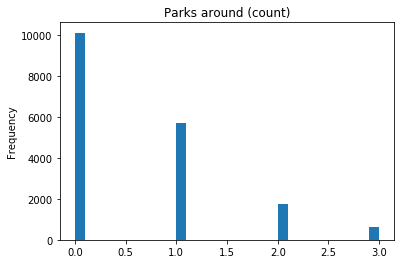

In [180]:
real_estate_ads['parks_around3000'].plot(kind='hist', bins=30, title='Parks around (count)')

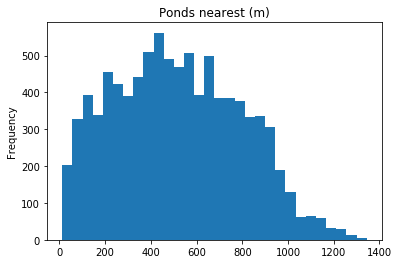

In [181]:
real_estate_ads['ponds_nearest'].plot(kind='hist', bins=30, title='Ponds nearest (m)')

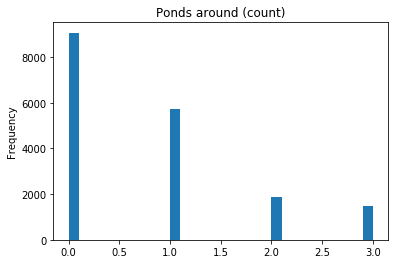

In [182]:
real_estate_ads['ponds_around3000'].plot(kind='hist', bins=30, title='Ponds around (count)')

<b>Причиной отсутствия этих картографических данных может заключаться в том, что поблизости этих жилых помещений вообще нет парков или водоёмов. Либо эти данные были утеряны.</b>

Посмотрим, какие еще пропущенные значения остались в наших данных:

In [183]:
miss_cols = pd.Series(dtype='float64')
for col in real_estate_ads:
    if real_estate_ads[col].isnull().any() == True:
        miss_cols[col] = real_estate_ads[col].isna().sum()
print(miss_cols.sort_values(ascending=False))

parks_nearest          15620
ponds_nearest          14589
balcony                11519
ceiling_height          9195
airports_nearest        5542
cityCenters_nearest     5519
parks_around3000        5518
ponds_around3000        5518
days_exposition         3181
kitchen_area            2278
living_area             1903
floors_total              86
locality_name             49
dtype: int64


### Столбец 'balcony'

<b>'balcony' — число балконов</b>. Очевидно, что если значение этого параметра пропущено, это означает, что балконов в квартире <b>0</b>.

<b>Пропущенных значений в данном столбце около половины, это странно, если только большинство квартир не находятся на нижних этажах (1-3 этажи).</b>

<b>Как правило, в стандартных жилых домах, все квартиры, находящиеся на 3 этаже и выше, имеют хотя бы 1 балкон. <b>По информации из источника (https://agent112.ru/stati/kvartira-bez-balkona-stoit-li-pokupat.html) около 15-20% жилых помещений не имеют балконов. Проверим, сколько таких жилых помещений, которые находятся выше 2 этажа и число их балконов равно 0.</b>

In [184]:
r = real_estate_ads.query('balcony == 0')
r[r['floor'] >= 3]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
12,10,3890000.0,54.0,2016-06-30T00:00:00,2,NaN,5.0,30.0,5,False,...,9.0,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
27,20,7100000.0,70.0,2017-05-12T00:00:00,3,2.60,17.0,49.0,11,False,...,9.2,0.0,Санкт-Петербург,29197.0,11456.0,2.0,452.0,1.0,779.0,151.0
29,9,8600000.0,100.0,2016-04-09T00:00:00,3,NaN,19.0,52.0,15,False,...,11.0,0.0,Санкт-Петербург,30394.0,11526.0,1.0,532.0,1.0,896.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23657,2,5990000.0,64.0,2017-04-21T00:00:00,2,NaN,19.0,31.0,16,False,...,11.0,0.0,Санкт-Петербург,37636.0,14479.0,0.0,NaN,1.0,1127.0,40.0
23666,9,8150000.0,80.0,2016-04-17T00:00:00,3,NaN,17.0,44.9,12,False,...,11.4,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,286.0
23676,19,3550000.0,36.4,2016-06-08T00:00:00,1,NaN,16.0,14.9,13,False,...,9.3,0.0,Санкт-Петербург,32228.0,11884.0,1.0,701.0,0.0,NaN,70.0
23686,8,3300000.0,31.0,2017-04-29T00:00:00,1,2.55,9.0,18.0,6,False,...,6.5,0.0,Санкт-Петербург,11751.0,11602.0,1.0,140.0,1.0,317.0,193.0


2557 объявлений, вполне укладывается в 15% от общего количества объявлений, оставим эти значения без изменений.

#### Замена пропущенных значений

Пропущенных значений в данном столбце - <b>11519</b>

Если все их заменить на 0, то получится, что практически у половины квартир балконов нет. Это не соответствует реальности. <b>Поэтому для пропущенных значений воспользуемся следующей логикой:</b>

- Если квартира находится на 3 этаже и выше, заменим ее пропущенное значение в параметре 'balcony' на значение 1.
- Если квартира находится на 1 или 2 этаже, заменим ее пропущенное значение в параметре 'balcony' на значение 0.

In [185]:
real_estate_ads.loc[(real_estate_ads['floor'] >= 3) & (real_estate_ads['balcony'].isnull()), 'balcony'] = 1
real_estate_ads.loc[(real_estate_ads['floor'] < 3) & (real_estate_ads['balcony'].isnull()), 'balcony'] = 0

#Проверим наличие пропущенных значений после замены
print('Кол-во пропущенных значений в столбце {}: {}'.format(
    'balcony', real_estate_ads['balcony'].isnull().sum())
     )

Кол-во пропущенных значений в столбце balcony: 0


#### Вывод и причины возникновения

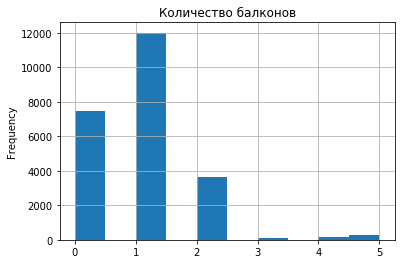

In [186]:
real_estate_ads['balcony'].plot(kind='hist', title='Количество балконов', grid=True)

Судя по гистограмме, можно сделать вывод, что большинство жилых помещений имеют хотя бы 1 балкон, что вполне соответствует реальности.

Немалая доля жилых помещений не имеет балконов вовсе, возможно это квартиры, расположенные на 1 или 2 этаже, или же это частные дома, где нет балконов, или же это 1-этажные или 2-х этажные дома.

<b>Причины возникновения пропущенных значений в данном столбце:</b>
    
- Отутствие балконов в квартире, в следствие чего продавец не указывает количество балконов, отсюда и берутся пропущенные значения
- Данные могли быть утеряны при транспортировке или обработке.

### Столбец 'ceiling_height'

<b>'ceiling_height' — высота потолков (м)</b> - пропущенных значений 9195

Данные из этого столбца наверняка были утеряны, либо же продавец поленился заполнять этот параметр. Заменить пропущенные значения нулями мы не можем, ведь это высота потолков, а она есть всегда. Придется заменять пропущенные значения средними. Рассмотрим столбец 'ceiling_height' подробнее.

In [187]:
real_estate_ads.pivot_table(index='ceiling_height', values='last_price', aggfunc='count')

,last_price
ceiling_height,
1.00,1
1.20,1
1.75,1
2.00,11
2.20,1
...,...
26.00,1
27.00,8
27.50,1


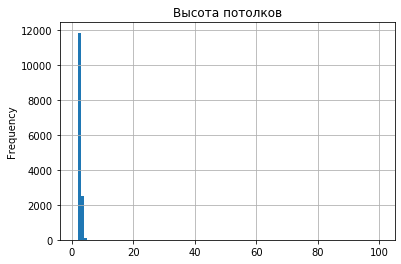

In [188]:
real_estate_ads['ceiling_height'].plot(kind='hist', bins=100, title='Высота потолков', grid=True)

Обратим внимание на сводную таблицу и гистограмму для столбца <b>'ceiling_height'</b>. Большинство значений находятся в нормальной зоне, но есть также и выбросы, такие как 100 метров, или 26 метров, или 1 метр (что тоже недопустимо для жилых помещений).

#### Замена пропущенных значений

Высота потолков в жилых помещениях регулируется регламентом.
Основываясь на источнике (http://www.remotvet.ru/questions/20610-kakaja-minimalnaja-vysota-potolka-po-normam.html) - <b>Независимо от года постройки для жилых зданий высота от пола до потолка должна быть в пределах 2,5-3,2 метров.</b>
Возьмем этот предел с запасом в 3.5 м, так как в некоторых "Сталинках" высота потолка могла доходить до 3.5 м.

Основываясь на этой логике, заполним пропущенные значения и избавимся от выбросов в данном столбце. Заполним средним значением высоты потолков - 2,85 м. ((2.5 + 3.2) / 2 = 2.85 м) 

In [189]:
real_estate_ads.loc[(real_estate_ads['ceiling_height'] < 2.5) | (real_estate_ads['ceiling_height'] > 3.5), 'ceiling_height'] = 2.85
real_estate_ads['ceiling_height'].fillna(2.85, inplace=True)

#Проверим наличие пропущенных значений после замены
print('Кол-во пропущенных значений в столбце {}: {}'.format(
    'ceiling_height', real_estate_ads['ceiling_height'].isnull().sum())
     )

Кол-во пропущенных значений в столбце ceiling_height: 0


#### Вывод и причины возникновения

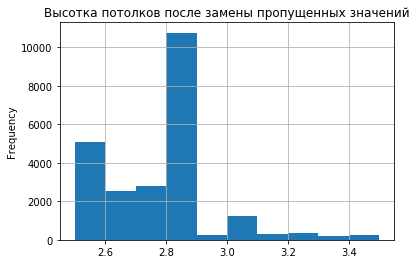

In [190]:
real_estate_ads['ceiling_height'].plot(kind='hist', title='Высотка потолков после замены пропущенных значений', grid=True)

Да, большое количество пропущенных значений, замененное на значение 2.85, очень повлияли на конечную гистограмму. Но, все равно, теперь данные для этого параметра выглядят нормально и логично.

Можно сделать вывод, что в большинстве объявлений квартиры обладают потолком в пределах 2.5 - 2.9 м. Это говорит о том, что это все стандартные жилые дома, такие, какими мы привыкли их видеть, мало элитных домов с потолками высотой больше 3 м.

<b>Причины возникновения пропущенных значений:</b>

- Данные были утеряны при обработке или транспортировке
- Продавец решил не измерять высоту потолков и не указывать этот параметр, так как, вполне вероятно, что большинству людей это не важно, ведь мы привыкли, что чаще всего в квартирах стандартные потолки около 2.5 - 2.9 м.

### Столбец 'airports_nearest'

#### Замена пропущенных значений

<b>'airports_nearest' — расстояние до ближайшего аэропорта в метрах (м)</b> - пропущенных значений 5542

Эти данные являются картографическими и они были пропущены, <b>считаю правильным ОСТАВИТЬ эти пропущенные значения, ведь они означают, что аэропорт от квартиры находится слишком далеко</b>

#### Вывод и причины возникновения

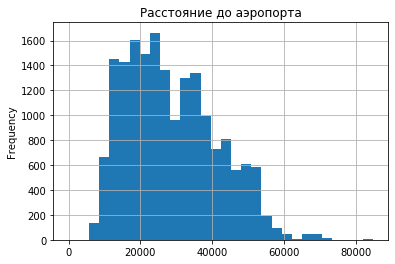

In [191]:
real_estate_ads['airports_nearest'].plot(kind='hist', bins=30, title='Расстояние до аэропорта', grid=True)

Мы видим более менее "нормальное распределение". Это не может не радовать.

Основываясь на гистрограмме, можно сделать вывод, что большинство жилых помещений находятся от аэропорта на расстоянии около 15000-40000 м. Это достаточно недалеко.

<b>Причиной возникновения пропущенных значений для данного параметра наиболее вероятно является утеря данных при их обработке или транспортировке</b>

Взглянем еще раз, какие пропущенные значения остались в наших данных:

In [192]:
miss_cols = pd.Series(dtype='float64')
for col in real_estate_ads:
    if real_estate_ads[col].isnull().any() == True:
        miss_cols[col] = real_estate_ads[col].isna().sum()
print(miss_cols.sort_values(ascending=False))

parks_nearest          15620
ponds_nearest          14589
airports_nearest        5542
cityCenters_nearest     5519
parks_around3000        5518
ponds_around3000        5518
days_exposition         3181
kitchen_area            2278
living_area             1903
floors_total              86
locality_name             49
dtype: int64


### Столбец 'days_exposition'

#### Замена пропущенных значений

<b>'days_exposition'</b> — сколько дней было размещено объявление (от публикации до снятия) - пропущенных значений 3181

<b>Вполне приемлимо будет оставить пропущенные значения, ведь они могут означать, что объявление все еще не снято</b>.

#### Вывод и причины возникновения

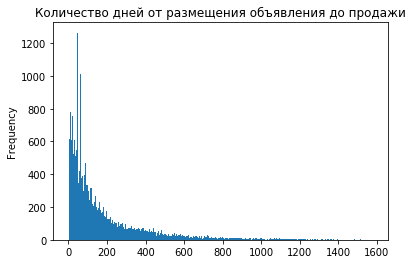

In [193]:
real_estate_ads['days_exposition'].plot(kind='hist', bins=300, title='Количество дней от размещения объявления до продажи')

Основываясь на диаграмме, можно сделать вывод, что большинство квартир продаются достаточно быстро - до 200 дней в среднем.

<b>Причины возникновения пропущенных значений:</b>

- Объявление до сих пор не было снято
- Данные были утеряны.

### Столбец 'locality_name'

#### Замена пропущенных значений

Как мы видим, в столбце 'locality_name' у нас есть 49 пропущенное значение, от них надо избавиться, <b>считаю самым действенным способом - удалить их, чтобы не присваивать им какие-либо средине значения и не искажать данные о их местоположении.</b>

In [194]:
ads_to_drop = real_estate_ads[real_estate_ads['locality_name'].isnull()]
real_estate_ads.drop(ads_to_drop.index, inplace=True)


# Проверим наличие пропущенных значений после удаления
print('Кол-во пропущенных значений в столбце {}: {}'.format(
    'locality_name', real_estate_ads['locality_name'].isnull().sum())
     )

Кол-во пропущенных значений в столбце locality_name: 0


### Обработка выбросов

В данном пункте мы обработаем выбросы и несоответствия, такие как:

- Невероятно большая цена
- Очень большая общая площадь
- Площадь кухни больше чем жилая площадь

Рассмотрим столбцы с этими данными

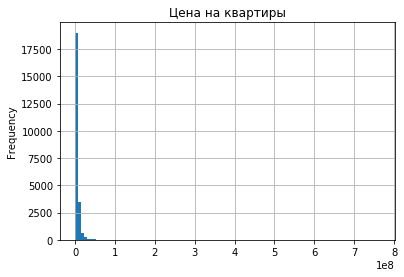

In [195]:
real_estate_ads['last_price'].plot(kind='hist', bins=100, title='Цена на квартиры', grid=True)

Как мы видим на гистограмме, цена квартиры в наших объявлениях может доходить аж до 800 млн. Это безумно много, скорее всего, это ошибочные данные.

Определим минимальный и максимальный порог для цен на квартиры. Цена на квартиру может начинаться примерно от 1 млн. (в деревнях и глубинках) и может доходить до 250 млн. (возможно это дорогие апартаменты или большие квартиры рядом с центром города).

Удалим все объявление, в которых цена выходит за пределы от 1 млн. до 250 млн.

In [196]:
ads_to_drop = real_estate_ads.query('last_price < 1000000 or last_price > 250000000')

real_estate_ads.drop(ads_to_drop.index, inplace=True)

real_estate_ads.shape

(23419, 22)

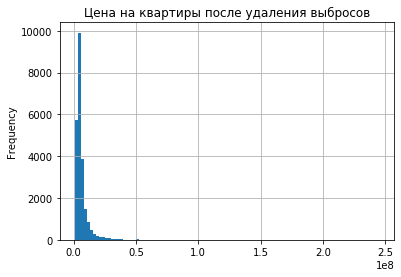

In [197]:
real_estate_ads['last_price'].plot(kind='hist', bins=100, title='Цена на квартиры после удаления выбросов', grid=True)

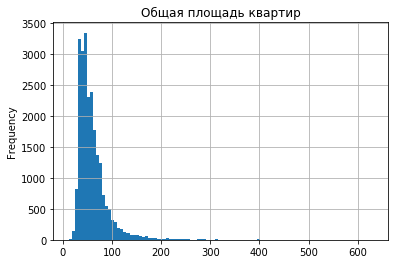

In [198]:
real_estate_ads['total_area'].plot(kind='hist', bins=100, title='Общая площадь квартир', grid=True)

Как мы видим на гистограмме, общая площадь квартиры может доходить до 600 кв. м. Это достаточно много, но вполне реально, надо лишь убедиться, что это адекватные данные. Сравним стоимость этих квартир, у которых площадь больше 400 кв. м.

In [199]:
real_estate_ads.query('total_area > 400')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
660,3,49950000.0,483.90,2017-10-04T00:00:00,7,3.20,6.0,312.5,4,False,...,26.40,1.0,Санкт-Петербург,23079.0,945.0,3.0,461.0,3.0,22.0,391.0
3117,19,140000000.0,631.00,2019-03-30T00:00:00,7,2.85,5.0,NaN,5,False,...,60.00,1.0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
3676,12,28789000.0,441.98,2019-01-23T00:00:00,4,2.85,6.0,NaN,6,False,...,35.05,1.0,Санкт-Петербург,20552.0,5181.0,0.0,NaN,0.0,NaN,NaN
4237,1,50000000.0,517.00,2017-10-14T00:00:00,7,2.85,4.0,332.0,3,False,...,22.00,1.0,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN
5358,20,65000000.0,590.00,2019-02-14T00:00:00,15,3.50,6.0,409.0,3,False,...,100.00,1.0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
5893,3,230000000.0,500.00,2017-05-31T00:00:00,6,2.85,7.0,NaN,7,False,...,40.00,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0
6221,8,34000000.0,470.30,2018-01-14T00:00:00,4,2.85,3.0,248.7,3,False,...,40.00,1.0,Санкт-Петербург,43756.0,15459.0,1.0,852.0,3.0,122.0,179.0
6621,20,99000000.0,488.00,2017-04-09T00:00:00,5,2.95,20.0,216.0,17,False,...,50.00,1.0,Санкт-Петербург,27641.0,4598.0,1.0,646.0,1.0,368.0,351.0
8018,20,84000000.0,507.00,2015-12-17T00:00:00,5,2.85,7.0,301.5,7,True,...,45.50,1.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0
9826,1,43185328.0,494.10,2017-05-12T00:00:00,1,2.85,12.0,NaN,3,False,...,NaN,0.0,Санкт-Петербург,28529.0,6832.0,1.0,592.0,0.0,NaN,5.0


Стоимость таких квартир начинается от 20 млн. и доходит до 240 млн. Я считаю, что это вполне логичные цифры.

In [200]:
real_estate_ads.query('living_area < kitchen_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,False,...,41.00,1.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,2.85,26.0,10.60,6,False,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
51,7,45000000.0,161.00,2017-10-17T00:00:00,3,3.20,8.0,38.00,4,False,...,50.00,1.0,Санкт-Петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,541.0
53,7,4300000.0,39.10,2017-11-10T00:00:00,1,2.85,25.0,15.40,13,False,...,15.50,2.0,посёлок Парголово,52611.0,18783.0,0.0,NaN,0.0,NaN,6.0
101,4,3000000.0,37.00,2019-03-23T00:00:00,1,2.75,10.0,12.00,3,False,...,13.00,1.0,садовое товарищество Новая Ропша,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23388,7,5400000.0,43.00,2017-04-24T00:00:00,1,2.85,18.0,12.00,8,False,...,20.00,0.0,Санкт-Петербург,25108.0,15940.0,0.0,NaN,0.0,NaN,124.0
23481,1,3000000.0,37.29,2019-04-15T00:00:00,1,2.85,19.0,10.08,10,False,...,16.88,1.0,Санкт-Петербург,37006.0,15157.0,0.0,NaN,0.0,NaN,7.0
23573,8,6290000.0,47.67,2019-03-20T00:00:00,1,2.85,12.0,13.59,12,False,...,17.87,2.0,Санкт-Петербург,35726.0,16028.0,1.0,253.0,2.0,99.0,19.0
23574,14,64990000.0,139.00,2015-11-24T00:00:00,3,3.00,8.0,3.00,8,False,...,16.00,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0


Эти данные искажены, считаю, что лучше от них избавиться.

In [201]:
ads_to_drop = real_estate_ads.query('living_area < kitchen_area')
real_estate_ads.drop(ads_to_drop.index, inplace=True)
real_estate_ads.shape

(23065, 22)

Мы обработали очевидные выбросы, теперь посмотрим, какие пропущенные значения еще остались.

In [202]:
miss_cols = pd.Series(dtype='float64')
for col in real_estate_ads:
    if real_estate_ads[col].isnull().any() == True:
        miss_cols[col] = real_estate_ads[col].isna().sum()
print(miss_cols.sort_values(ascending=False))

parks_nearest          15143
ponds_nearest          14160
airports_nearest        5242
cityCenters_nearest     5219
parks_around3000        5218
ponds_around3000        5218
days_exposition         3083
kitchen_area            2221
living_area             1855
floors_total              84
dtype: int64


In [203]:
real_estate_ads = real_estate_ads.reset_index(drop=True)

### Столбец 'kitchen_area' и 'living_area'

<b>'kitchen_area' — площадь кухни в квадратных метрах (м²)</b> - пропущенных значений 1555

<b>'living_area' — жилая площадь в квадратных метрах(м²)</b> - пропущенных значений 1276

Эти пропущенные значения мы можем заменить, рассчитав среднюю долю жилой площади и площади кухни относительно общей площади квартиры.

Рассчитаем эти показатели.

In [204]:
total_area_living_area = real_estate_ads['living_area'] / real_estate_ads['total_area']
print('Медиана доли жилой площади относительно общей площади: {:.2%}'.format(total_area_living_area.median()))

total_area_kitchen_area = real_estate_ads['kitchen_area'] / real_estate_ads['total_area']
print('Медиана доли площади кухни относительно общей площади: {:.2%}'.format(total_area_kitchen_area.median()))

Медиана доли жилой площади относительно общей площади: 57.01%
Медиана доли площади кухни относительно общей площади: 17.10%


Показатели достаточно логичные. Заполним пропущенные значения.

#### Заполнение пропущенных значений

In [205]:
living_area_missing = real_estate_ads[real_estate_ads['living_area'].isnull()].index
kitchen_area_missing = real_estate_ads[real_estate_ads['kitchen_area'].isnull()].index

In [206]:
for row in living_area_missing:
    real_estate_ads.loc[row, 'living_area'] = real_estate_ads['total_area'][row] * 0.5701

# Проверим наличие пропущенных значений после замены
print('Кол-во пропущенных значений в столбце {}: {}'.format(
    'living_area', real_estate_ads['living_area'].isnull().sum())
     )

for row in kitchen_area_missing:
    real_estate_ads.loc[row, 'kitchen_area'] = real_estate_ads['total_area'][row] * 0.1710
    
# Проверим наличие пропущенных значений после замены
print('Кол-во пропущенных значений в столбце {}: {}'.format(
    'kitchen_area', real_estate_ads['kitchen_area'].isnull().sum())
     )


Кол-во пропущенных значений в столбце living_area: 0
Кол-во пропущенных значений в столбце kitchen_area: 0


#### Вывод и причины возникновения

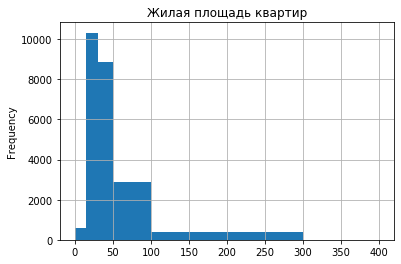

In [207]:
real_estate_ads['living_area'].plot(kind='hist', bins=[0, 15, 30, 50, 100, 300, 400], title='Жилая площадь квартир', grid=True)

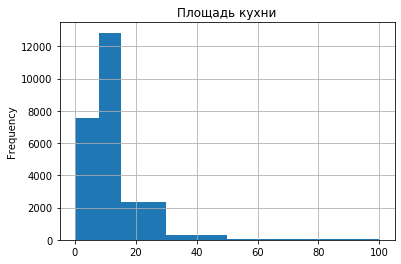

In [208]:
real_estate_ads['kitchen_area'].plot(kind='hist', bins=[0, 8, 15, 30, 50, 100], title='Площадь кухни', grid=True)

Основываясь на диаграммах, можно сделать вывод, что большинство квартир имеют жилую площадь в пределах 50 кв. м., а их кухни как правило площадью до 20 кв. м.

<b>Причины возникновения пропущенных значений:</b>

- Продавец не стал замерять жилую площадь или площадь кухни
- Продавец не указал эти данные, но указал общую площадь квартиры
- Данные были утеряны

### Столбец 'floors_total'

<b>'floors_total' — всего этажей в доме</b> - пропущенных значений 84

Вполне вероятно, что продавец не указал количество этажей в доме, или этот дом является частным или одноэтажным, рассмотрим этот столбец подробнее.

In [209]:
real_estate_ads[real_estate_ads['floors_total'].isnull()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
178,12,11640000.0,65.2,2018-10-02T00:00:00,2,2.85,NaN,30.80000,4,False,...,12.0000,1.0,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
229,4,2438033.0,28.1,2016-11-23T00:00:00,1,2.85,NaN,20.75000,1,False,...,4.8051,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
440,4,9788348.0,70.8,2015-08-01T00:00:00,2,2.85,NaN,38.40000,12,False,...,10.6300,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
650,4,6051191.0,93.6,2017-04-06T00:00:00,3,2.85,NaN,47.10000,8,False,...,16.8000,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1709,5,3600000.0,39.0,2017-04-22T00:00:00,1,2.85,NaN,22.23390,9,False,...,6.6690,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21163,7,6800000.0,57.0,2017-05-01T00:00:00,2,2.85,NaN,32.49570,21,False,...,9.7470,0.0,Санкт-Петербург,17618.0,14600.0,2.0,104.0,0.0,NaN,36.0
21931,5,8500000.0,63.5,2017-05-24T00:00:00,2,2.80,NaN,36.20135,3,False,...,10.8585,1.0,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22043,4,4574160.0,64.5,2017-04-02T00:00:00,2,2.85,NaN,31.70000,20,False,...,14.4000,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22194,0,14569263.0,110.4,2016-11-20T00:00:00,3,2.85,NaN,45.38000,6,False,...,23.4200,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0


#### Замена пропущенных значений

Можно заметить, что количество этажей в доме не указано, но квартира находится, например, на 18 этаже или на 9 этаже. Это говорит о том, что дом имеет минимум это количество этажей.

<b>Заполним эти пропущенные значения этажем, на котором располагается квартира</b>

In [210]:
total_floors_missing = real_estate_ads[real_estate_ads['floors_total'].isnull()].index

for row in total_floors_missing:
    real_estate_ads.loc[row, 'floors_total'] = real_estate_ads['floor'][row]
    
    
# Проверим наличие пропущенных значений после замены
print('Кол-во пропущенных значений в столбце {}: {}'.format(
    'floors_total', real_estate_ads['floors_total'].isnull().sum())
     )


Кол-во пропущенных значений в столбце floors_total: 0


#### Вывод и причины возникновения

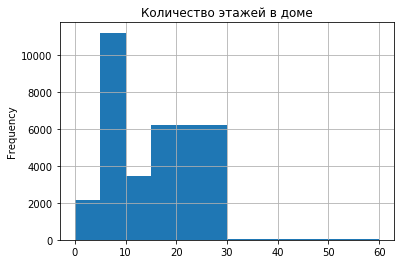

In [211]:
real_estate_ads['floors_total'].plot(kind='hist', bins = [0, 5, 10, 15, 30, 60], title='Количество этажей в доме', grid=True)

Основываясь на гистограмме, можно сделать вывод, что большинство домов имеют около 5-10, но есть и исключения, такие как 60-этажные дома, это вполне реально.

<b>Причины пропущенных значений:</b>

- Дом имеет 1 этаж
- Продавец не указал общее количество этажей
- Данные были утеряны

In [212]:
# Проверим оставшиеся пропущенные значения
miss_cols = pd.Series(dtype='float64')
for col in real_estate_ads:
    if real_estate_ads[col].isnull().any() == True:
        miss_cols[col] = real_estate_ads[col].isna().sum()
print(miss_cols.sort_values(ascending=False))

parks_nearest          15143
ponds_nearest          14160
airports_nearest        5242
cityCenters_nearest     5219
parks_around3000        5218
ponds_around3000        5218
days_exposition         3083
dtype: int64


### Столбец 'cityCenters_nearest'

In [213]:
real_estate_ads[real_estate_ads['cityCenters_nearest'].isnull()]
#real_estate_ads.query('cityCenters_nearest.isnull()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
4,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.85,12.0,14.40000,5,False,...,9.1000,1.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.85,27.0,15.43000,26,False,...,8.8100,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
10,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.85,5.0,30.00000,5,False,...,9.0000,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
20,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00000,15,False,...,11.0000,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
28,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.85,9.0,18.69928,2,False,...,5.6088,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23049,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50000,3,False,...,5.5000,1.0,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23058,2,1350000.0,30.00,2017-07-07T00:00:00,1,2.85,5.0,17.50000,4,False,...,6.0000,1.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23061,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.85,5.0,38.00000,4,False,...,8.5000,1.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23062,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.85,3.0,29.70000,1,False,...,9.6957,0.0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Замена пропущенных значений

Эти данные являются картографическими, пропущенные значения имеют смысл, они говорят о том, что центр находится слишком далеко. Считаю правильным ОСТАВИТЬ эти пропущенные значения.

#### Вывод и причины возникновения

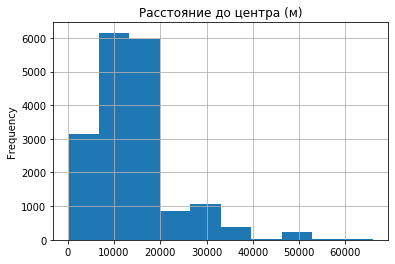

In [214]:
real_estate_ads['cityCenters_nearest'].plot(kind='hist', title='Расстояние до центра (м)', grid=True)

Основываясь на гистограмме, можем сделать вывод, что большинство квартир находятся в 20 км от центра, неплохой показатель.

<b>Причиной пропущенного значения могло является:</b>

- Утеря картографических данных

In [215]:
# Проверим оставшиеся пропущенные значения
miss_cols = pd.Series(dtype='float64')
for col in real_estate_ads:
    if real_estate_ads[col].isnull().any() == True:
        miss_cols[col] = real_estate_ads[col].isna().sum()
print(miss_cols.sort_values(ascending=False))

parks_nearest          15143
ponds_nearest          14160
airports_nearest        5242
cityCenters_nearest     5219
parks_around3000        5218
ponds_around3000        5218
days_exposition         3083
dtype: int64


<b>Важных пропущенных значений не осталось! Теперь приведем все данные к нужному типу!</b>

### Приводение данных к нужным типам

In [216]:
real_estate_ads = real_estate_ads.reset_index(drop=True)
real_estate_ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23065 entries, 0 to 23064
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23065 non-null  int64  
 1   last_price            23065 non-null  float64
 2   total_area            23065 non-null  float64
 3   first_day_exposition  23065 non-null  object 
 4   rooms                 23065 non-null  int64  
 5   ceiling_height        23065 non-null  float64
 6   floors_total          23065 non-null  float64
 7   living_area           23065 non-null  float64
 8   floor                 23065 non-null  int64  
 9   is_apartment          23065 non-null  bool   
 10  studio                23065 non-null  bool   
 11  open_plan             23065 non-null  bool   
 12  kitchen_area          23065 non-null  float64
 13  balcony               23065 non-null  float64
 14  locality_name         23065 non-null  object 
 15  airports_nearest   

<b>Список столбцов, которые мы преобразуем, к какому типу и почему:</b>

- 'last_price' преобразуем в int, чтобы цена была целым числом
- 'first_day_exposition' преобразуем в data, чтобы в дальнейшем использовать этот столбец для анализа, оставим только дату, без времени, так как везде стоит время 00:00.
- 'floors_total' преобразуем в int, ведь количество этажей в доме всегда целое число
- 'is_apartment', 'studio', 'open_plan' - преобразуем в int, то есть в 1 или 0 для того, чтобы использовать эти данные для анализа
- 'balcony' преобразуем в int, ведь количество балконов всегда целое число
- 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition' - преобразуем в int, ведь это все целые числа.

In [217]:
real_estate_ads['last_price'] = real_estate_ads['last_price'].astype(int)
real_estate_ads['first_day_exposition'] = pd.to_datetime(
    real_estate_ads['first_day_exposition'], format='%Y-%m-%d'
)
real_estate_ads['floors_total'] = real_estate_ads['floors_total'].astype(int)
real_estate_ads['is_apartment'] = real_estate_ads['is_apartment'].astype(int)
real_estate_ads['studio'] = real_estate_ads['studio'].astype(int)
real_estate_ads['open_plan'] = real_estate_ads['open_plan'].astype(int)
real_estate_ads['balcony'] = real_estate_ads['balcony'].astype(int)
real_estate_ads['airports_nearest'] = real_estate_ads['airports_nearest'].astype('int64', errors='ignore')
real_estate_ads['cityCenters_nearest'] = real_estate_ads['cityCenters_nearest'].astype('int64', errors='ignore')
real_estate_ads['parks_around3000'] = real_estate_ads['parks_around3000'].astype('int64', errors='ignore')
real_estate_ads['parks_nearest'] = real_estate_ads['parks_nearest'].astype('int64', errors='ignore')
real_estate_ads['ponds_around3000'] = real_estate_ads['ponds_around3000'].astype('int64', errors='ignore')
real_estate_ads['ponds_nearest'] = real_estate_ads['ponds_nearest'].astype('int64', errors='ignore')
real_estate_ads['days_exposition'] = real_estate_ads['days_exposition'].astype('int64', errors='ignore')

In [218]:
real_estate_ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23065 entries, 0 to 23064
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23065 non-null  int64         
 1   last_price            23065 non-null  int32         
 2   total_area            23065 non-null  float64       
 3   first_day_exposition  23065 non-null  datetime64[ns]
 4   rooms                 23065 non-null  int64         
 5   ceiling_height        23065 non-null  float64       
 6   floors_total          23065 non-null  int32         
 7   living_area           23065 non-null  float64       
 8   floor                 23065 non-null  int64         
 9   is_apartment          23065 non-null  int32         
 10  studio                23065 non-null  int32         
 11  open_plan             23065 non-null  int32         
 12  kitchen_area          23065 non-null  float64       
 13  balcony         

## Расчёты и добавление результатов в таблицу

Добавление столбца "цена за квадратный метр"

In [219]:
real_estate_ads['price_per_square_meter'] = real_estate_ads['last_price'] / real_estate_ads['total_area']

День недели, месяц и год

In [220]:
real_estate_ads['year_exposition'] = real_estate_ads['first_day_exposition'].dt.year
real_estate_ads['month_exposition'] = real_estate_ads['first_day_exposition'].dt.month
real_estate_ads['day_exposition'] = real_estate_ads['first_day_exposition'].dt.day

Этаж квартиры; варианты — первый, последний, другой;

In [221]:
real_estate_ads['home_floor'] = 0
for row in range(real_estate_ads.shape[0]):
    if real_estate_ads['floor'][row] == 1:
        real_estate_ads.loc[row, 'home_floor'] = 'первый'
    elif real_estate_ads['floor'][row] == real_estate_ads['floors_total'][row]:
        real_estate_ads.loc[row, 'home_floor'] = 'последний'
    else:
        real_estate_ads.loc[row, 'home_floor'] = 'другой'
    
real_estate_ads['home_floor']

0        другой
1        первый
2        другой
3        другой
4        другой
          ...  
23060    другой
23061    другой
23062    первый
23063    другой
23064    первый
Name: home_floor, Length: 23065, dtype: object

Cоотношение жилой и общей площади, а также отношение площади кухни к общей.

In [222]:
real_estate_ads['total_living_area'] = real_estate_ads['living_area'] / real_estate_ads['total_area']
real_estate_ads['total_kitchen_area'] = real_estate_ads['kitchen_area'] / real_estate_ads['total_area']

total_area_living_area = real_estate_ads['living_area'] / real_estate_ads['total_area']
print('Медиана доли жилой площади относительно общей площади: {:.2%}'.format(total_area_living_area.median()))

total_area_kitchen_area = real_estate_ads['kitchen_area'] / real_estate_ads['total_area']
print('Медиана доли площади кухни относительно общей площади: {:.2%}'.format(total_area_kitchen_area.median()))

Медиана доли жилой площади относительно общей площади: 57.01%
Медиана доли площади кухни относительно общей площади: 17.10%


## Исследовательский анализ данных

Изучим следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.

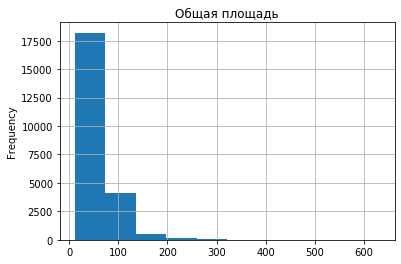

In [223]:
real_estate_ads['total_area'].plot(kind='hist', title='Общая площадь', grid=True)

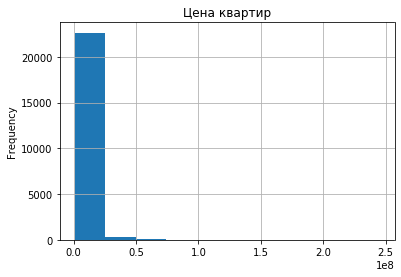

In [224]:
real_estate_ads['last_price'].plot(kind='hist', title='Цена квартир', grid=True)

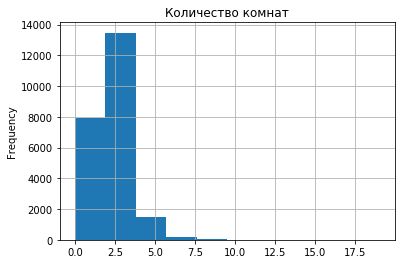

In [225]:
real_estate_ads['rooms'].plot(kind='hist', title='Количество комнат', grid=True)

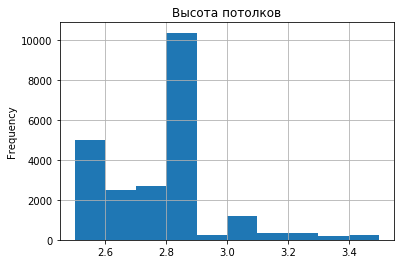

In [226]:
real_estate_ads['ceiling_height'].plot(kind='hist', title='Высота потолков', grid=True)

Изучим время продажи квартиры. Построим гистограмму. Посчитаем среднее и медиану. Опишем, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

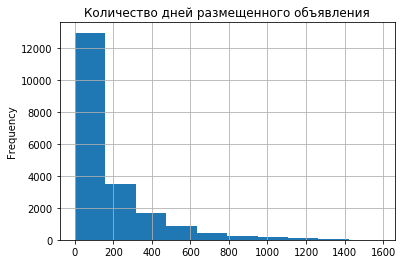

In [227]:
real_estate_ads['days_exposition'].plot(kind='hist', title='Количество дней размещенного объявления', grid=True)

In [228]:
print('Медиана времени продажи квартиры: {:.2f}'.format(real_estate_ads['days_exposition'].median()))
print('Среднее время продажи квартиры: {:.2f}'.format(real_estate_ads['days_exposition'].mean()))

Медиана времени продажи квартиры: 95.00
Среднее время продажи квартиры: 180.77


Основываясь на медиане, можно сказать, что продажа квартиры обычно занимает 3 месяца.

Слишком быстрой продажей квартиры можно считать продажу за 5 дней и быстрее, ведь покупателям нужно как минимум осмотреть квартиру и подготовить деньги, документы.

Нельзя точно сказать, когда можно считать продажу необычно долгой, ведь квартира - это дорогая недвижимость, и она не всегда может продаться даже за 1 год. Но в рамках этого проекта, допустим, что необычно долгое время продажи квартиры - 1000 дней и больше.

<b>Уберем редкие и выбивающиеся значения. Опишем, какие особенности обнаружили.</b>

Эти действия были проделаны в разделе "Обработка выбросов". Но в столбце "время продажи" редкие значения не были убраны.

In [229]:
ads_to_drop = real_estate_ads.query('days_exposition < 5 or days_exposition > 1000')
ads_to_drop

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,year_exposition,month_exposition,day_exposition,home_floor,total_living_area,total_kitchen_area
90,3,3500000,29.5,2019-04-26,1,2.50,5,15.60000,2,0,...,0.0,NaN,4.0,118644.067797,2019,4,26,другой,0.528814,0.186441
104,2,7497600,62.5,2015-12-08,2,2.85,5,35.50000,5,0,...,0.0,NaN,1048.0,119961.600000,2015,12,8,последний,0.568000,0.152000
281,20,3850000,37.0,2018-10-14,1,2.50,16,18.20000,15,0,...,0.0,NaN,3.0,104054.054054,2018,10,14,другой,0.491892,0.237838
339,4,5990000,43.5,2015-05-08,1,3.00,5,25.00000,4,0,...,0.0,NaN,1292.0,137701.149425,2015,5,8,другой,0.574713,0.216092
354,19,12500000,85.0,2018-09-21,3,2.85,6,56.50000,6,0,...,1.0,36.0,4.0,147058.823529,2018,9,21,последний,0.664706,0.258824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22798,17,8778000,47.5,2014-12-29,1,3.00,7,27.07975,4,0,...,3.0,204.0,1360.0,184800.000000,2014,12,29,другой,0.570100,0.246316
22814,0,2500000,27.7,2017-09-28,0,2.85,24,18.00000,4,0,...,NaN,NaN,4.0,90252.707581,2017,9,28,другой,0.649819,0.171000
22873,11,3530000,36.1,2017-11-17,1,2.85,10,19.10000,8,0,...,2.0,129.0,4.0,97783.933518,2017,11,17,другой,0.529086,0.193906
22910,10,1500000,43.7,2016-06-28,2,2.55,3,28.00000,2,0,...,NaN,NaN,1007.0,34324.942792,2016,6,28,другой,0.640732,0.167048


604 объявления, время продажи которых выходит за рамки адекватного. Избавимся от них.

In [230]:
real_estate_ads.drop(ads_to_drop.index, inplace=True)
real_estate_ads.shape

(22461, 29)

In [231]:
real_estate_ads = real_estate_ads.reset_index(drop=True)

Какие факторы больше всего влияют на стоимость квартиры? Изучим, зависит ли цена от площади, числа комнат, удалённости от центра. Изучим зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Также изучим зависимость от даты размещения: дня недели, месяца и года.

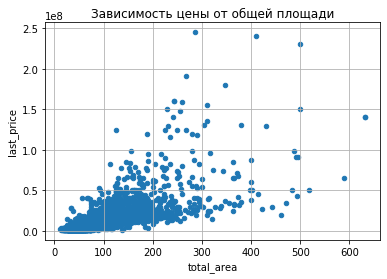

In [232]:
real_estate_ads.plot(x='total_area', y='last_price', kind='scatter', title='Зависимость цены от общей площади', grid=True)

<b>Как мы видим на графике, общая площадь напрямую влияет на стоимость квартиры, особенно когда площадь в пределах до 200 кв. м., после этой отметки зависимость продолжает оставаться, но слабеет.

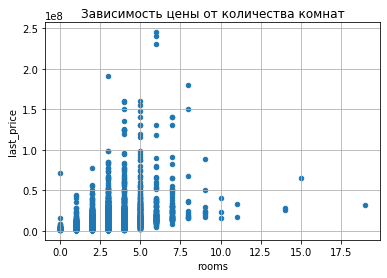

In [233]:
real_estate_ads.plot(x='rooms', y='last_price', kind='scatter', title='Зависимость цены от количества комнат', grid=True)

<b>Количество комнат также влияет на стоимость квартиры, хотя есть и такие квартиры, где 5 комнат, но стоят они так же, как и с 2 комнатами.
    
Но, все квартиры дороже 100 млн, имеют минимум 3 комнаты.

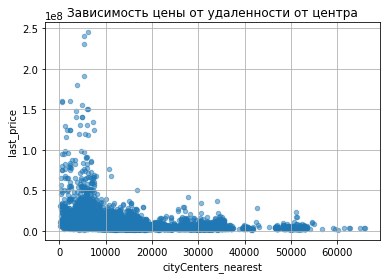

In [234]:
real_estate_ads.plot(x='cityCenters_nearest', y='last_price', kind='scatter', alpha=0.5, title='Зависимость цены от удаленности от центра', grid=True)

<b>Здесь мы также видим зависимость, чем ближе квартира к центру - тем дороже ее цена. Самые дорогие квартиры располагаются в пределах 10 км от центра.</b>

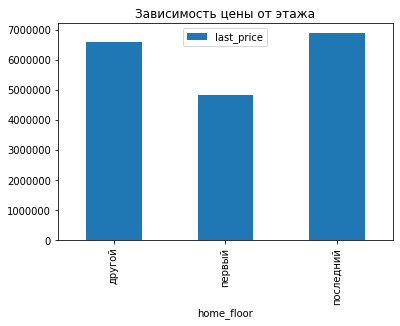

In [235]:
home_floor_price = real_estate_ads.pivot_table(index='home_floor', values='last_price', aggfunc='mean')
home_floor_price.plot.bar(title='Зависимость цены от этажа')

<b>В среднем, квартиры на последнем этаже самые дорогие, а самые дешевые квартиры в среднем на первом этаже. Это можно объяснить тем, что квартиры, который находятся на первом этаже, обычно шумные, там постоянно ходят люди, ездят машины и это все очень хорошо слышно, а также в таких квартирах зимой холоднее, чем на этажах выше.

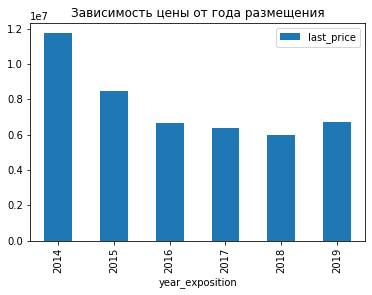

In [236]:
year_price = real_estate_ads.pivot_table(index='year_exposition', values='last_price', aggfunc='mean')
year_price.plot.bar(title='Зависимость цены от года размещения')

<b>Удивительный результат, казалось бы, цена на недвижимость каждый год росла, но наши данные показывают нам, что в среднем она с каждым годом снижалась, и только в 2019 году пошла вверх.

Вывод можно сделать следующий, в среднем с каждым годом квартиры становились дешевле.

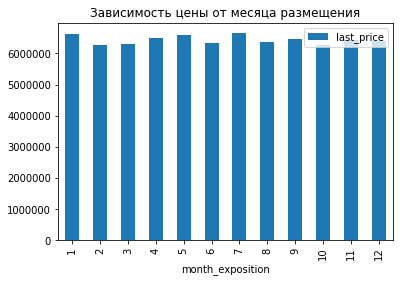

In [237]:
month_price = real_estate_ads.pivot_table(index='month_exposition', values='last_price', aggfunc='mean')
month_price.plot.bar(title='Зависимость цены от месяца размещения')

<b>С месяцем размещения результат очевидный, в среднем месяц размещения практически не влияет на стоимость квартиры, потому что экономика в целом и цены на недвижимость не меняются так быстро.

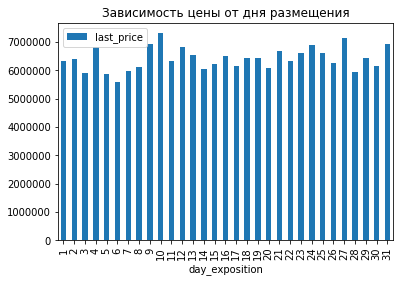

In [238]:
day_price = real_estate_ads.pivot_table(index='day_exposition', values='last_price', aggfunc='mean')
day_price.plot.bar(title='Зависимость цены от дня размещения')

<b>С днями размещения немного иная ситуация, мы можем увидеть слабую зависимость, но она есть. В целом, экономика и цены на недвижимость не меняются так быстро, чтобы каждый день цена менялась.

<b>Можно сделать вывод, что основные влияющие на стоимость квартиры факторы это: общая площадь, этаж, год размещения, а также удаленность от центра.</b>

Выберем 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.

In [239]:
locality_name_ads_count = real_estate_ads.pivot_table(index='locality_name', values='last_price', aggfunc='count')
locality_name_ads_count.columns = ['count']
top_10_locality = locality_name_ads_count.sort_values(by='count', ascending=False).head(10)
top_10_locality

,count
locality_name,
Санкт-Петербург,15027
посёлок Мурино,490
посёлок Шушары,423
Всеволожск,385
Пушкин,348
Колпино,329
посёлок Парголово,305
Гатчина,299
деревня Кудрово,277


Очевидно, что в большом городе будет больше всего объявлений.

In [240]:
real_estate_ads.query('locality_name in @top_10_locality.index').pivot_table(
    index='locality_name', values='price_per_square_meter').sort_values(by='price_per_square_meter', ascending=False)

,price_per_square_meter
locality_name,
Санкт-Петербург,113677.516181
Пушкин,102577.467363
деревня Кудрово,92469.304898
посёлок Парголово,89617.762289
посёлок Мурино,85558.193538
посёлок Шушары,78397.229739
Колпино,75297.303846
Гатчина,68902.681515
Всеволожск,68766.572031


В данном случае все тоже очевидно, в большом городе, где лучше развита инфраструктура, дороже и цена за квадратный метр.

In [241]:
real_estate_ads.query('locality_name in @top_10_locality.index').pivot_table(
    index='locality_name', values='last_price').sort_values(by='last_price', ascending=False)

,last_price
locality_name,
Санкт-Петербург,7.819283e+06
Пушкин,6.333561e+06
посёлок Парголово,4.512890e+06
деревня Кудрово,4.220645e+06
посёлок Шушары,4.122132e+06
Колпино,3.974286e+06
Всеволожск,3.813381e+06
посёлок Мурино,3.660346e+06
Гатчина,3.506252e+06


<b>Санкт-Петербург имеет самую высокую стоимость жилья. Выборг имеет самую низкую стоимость жилья</b>

Изучим предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделим квартиры в Санкт-Петербурге ('locality_name'). Задача — выяснить, какая область входит в центр. Создадим столбец с расстоянием до центра в километрах: округлим до целых значений. После этого посчитаем среднюю цену для каждого километра. Построим график: он должен показывать, как цена зависит от удалённости от центра. Определим границу, где график сильно меняется — это и будет центральная зона.

In [242]:
import math
import numpy as np
real_estate_ads['cityCenter_km'] = real_estate_ads['cityCenters_nearest'] / 1000
real_estate_ads['cityCenter_km'] = real_estate_ads['cityCenter_km'].apply(np.ceil)
cityCenter = real_estate_ads.query('locality_name == "Санкт-Петербург"')['cityCenters_nearest'] / 1000
cityCenter.apply(np.ceil)

0        17.0
2        14.0
3         7.0
5        12.0
7        16.0
         ... 
22451    17.0
22452     7.0
22453     5.0
22456     5.0
22459    11.0
Name: cityCenters_nearest, Length: 15027, dtype: float64

In [243]:
price_per_km = real_estate_ads.query('locality_name == "Санкт-Петербург"')['last_price'] / cityCenter
print('Средняя цена за каждый километр в Санкт-Петербурге: {}'.format(price_per_km.mean()))

Средняя цена за каждый километр в Санкт-Петербурге: 1430147.2794335845


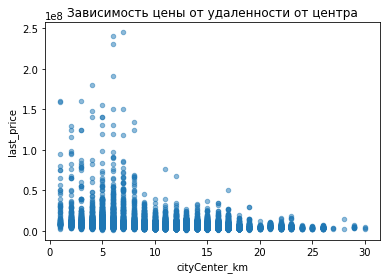

In [244]:
real_estate_ads.query('locality_name == "Санкт-Петербург"').plot(x='cityCenter_km', y='last_price', kind='scatter', alpha=0.5, title='Зависимость цены от удаленности от центра')

<b>Граница - 8 км удаленности от центра. Будем считать, что это центральная зона.</b>

Выделим сегмент квартир в центре. Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделаем выводы. Отличаются ли они от общих выводов по всему городу?

In [245]:
real_estate_central = real_estate_ads.query('cityCenter_km <= 8')
real_estate_central

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_per_square_meter,year_exposition,month_exposition,day_exposition,home_floor,total_living_area,total_kitchen_area,cityCenter_km
3,0,64900000,159.00,2015-07-24,3,2.85,14,90.6459,9,0,...,234.0,424.0,408176.100629,2015,7,24,другой,0.570100,0.171000,7.0
22,8,6500000,97.20,2015-10-31,2,2.85,3,46.5000,1,0,...,124.0,265.0,66872.427984,2015,10,31,первый,0.478395,0.201646,3.0
33,6,15500000,149.00,2017-06-26,5,2.85,5,104.0000,4,0,...,779.0,644.0,104026.845638,2017,6,26,другой,0.697987,0.114094,4.0
49,20,11795000,136.00,2017-09-22,6,3.00,2,94.0000,2,0,...,NaN,NaN,86727.941176,2017,9,22,последний,0.691176,0.080882,7.0
57,18,7990000,74.00,2017-08-24,2,2.85,4,43.0000,4,0,...,NaN,609.0,107972.972973,2017,8,24,последний,0.581081,0.270270,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22427,11,4250000,47.00,2016-05-20,1,2.85,6,18.2000,1,0,...,519.0,131.0,90425.531915,2016,5,20,первый,0.387234,0.310638,5.0
22443,13,5250000,43.00,2018-05-11,2,2.50,5,29.0000,2,0,...,660.0,80.0,122093.023256,2018,5,11,другой,0.674419,0.139535,8.0
22452,3,5500000,52.00,2018-07-19,2,2.85,5,31.0000,2,0,...,NaN,15.0,105769.230769,2018,7,19,другой,0.596154,0.115385,7.0
22453,11,9470000,72.90,2016-10-13,2,2.75,25,40.3000,7,0,...,806.0,519.0,129903.978052,2016,10,13,другой,0.552812,0.145405,5.0


3474 объявление, эти квартиры находятся в центре. Изучим параметры этих квартир.

In [246]:
print('Средняя площадь квартиры в центре города: {:.0f} кв. м.'.format(real_estate_central['total_area'].mean()))
print('Средняя цена квартиры в центре города: {:.0f}'.format(real_estate_central['last_price'].mean()))
print('Среднее количество комнат в квартире в центре города: {:.0f} комнаты'.format(real_estate_central['rooms'].mean()))
print('Средняя высота потолков в квартире в центре города: {:.0f} м'.format(real_estate_central['ceiling_height'].mean()))

Средняя площадь квартиры в центре города: 92 кв. м.
Средняя цена квартиры в центре города: 13923233
Среднее количество комнат в квартире в центре города: 3 комнаты
Средняя высота потолков в квартире в центре города: 3 м


Рассмотрим, какие факторы влияют на стоимость квартир в центре.

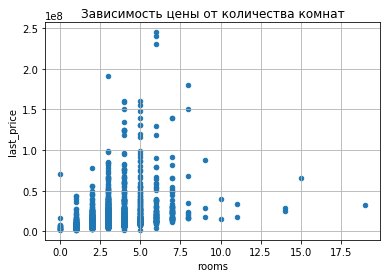

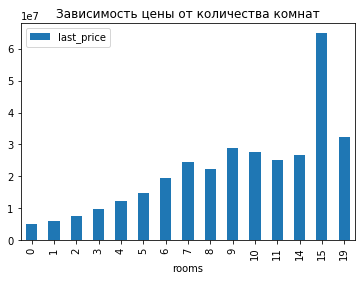

In [247]:
real_estate_central.plot(x='rooms', y='last_price', kind='scatter', title='Зависимость цены от количества комнат', grid=True)
real_estate_central.pivot_table(index='rooms', values='last_price', aggfunc='median').plot.bar(title='Зависимость цены от количества комнат')

Число комнат влияют на стоимость квартиры, чем их больше, тем дороже квартира, но такая тенденция продолжается в пределах 9 комнат, после этого значения число комнат не влияет на цену по разному.

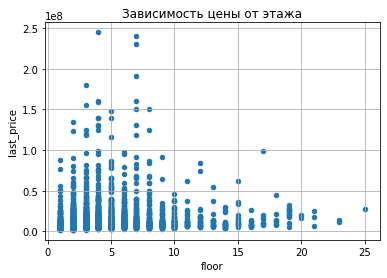

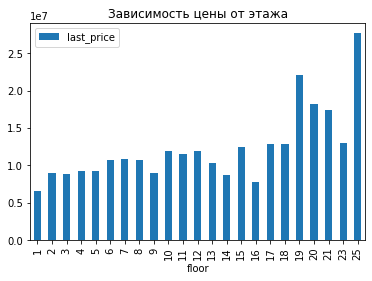

In [248]:
real_estate_central.plot(x='floor', y='last_price', kind='scatter', title='Зависимость цены от этажа', grid=True)
real_estate_central.pivot_table(index='floor', values='last_price', aggfunc='median').plot.bar(title='Зависимость цены от этажа')

В среднем, квартиры в центре, которые находятся на 1 этаже, дешевле всех остальных. Цена на квартиру растет в пределах от 1 до 8 этажа, а дальше идет разброс. Квартиры на самом высоком 25 этаже стоит дороже всех остальных.

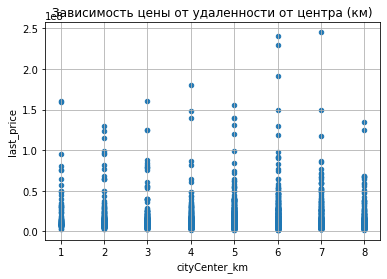

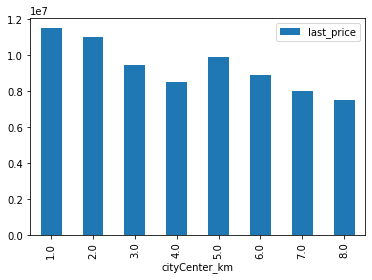

In [249]:
real_estate_central.plot(x='cityCenter_km', y='last_price', kind='scatter', title='Зависимость цены от удаленности от центра (км)', grid=True)
real_estate_central.pivot_table(index='cityCenter_km', values='last_price', aggfunc='median').plot.bar()

В среднем, удаленность от центра в центральном районе не сильно влияет на стоимость. Главное, что квартира находится в центральном районе, это и влияет на ее стоимость.

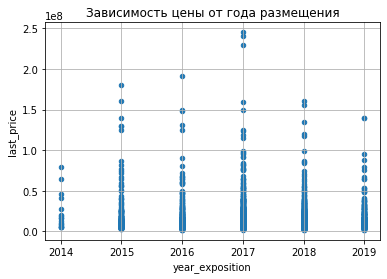

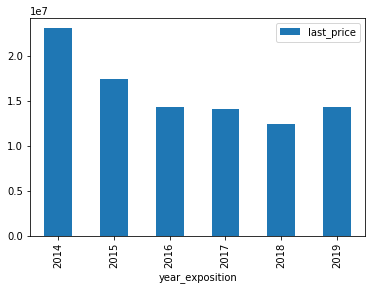

In [250]:
real_estate_central.plot(x='year_exposition', y='last_price', kind='scatter', title='Зависимость цены от года размещения', grid=True)
real_estate_central.pivot_table(index='year_exposition', values='last_price').plot.bar()

В среднем, в 2014 году квартиры в центре были дороже, и с каждым годом их цена снижалась.

Проверим, отличаются ли показатели в центре от показателей по всему городу.

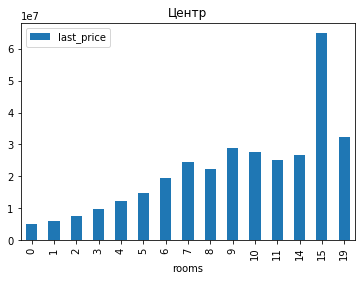

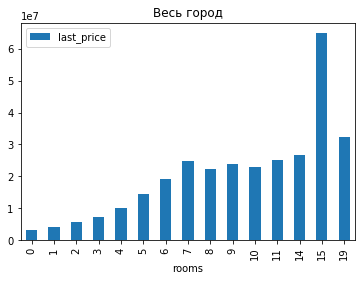

In [251]:
real_estate_spb = real_estate_ads.query('locality_name == "Санкт-Петербург"')

real_estate_central.pivot_table(index='rooms', values='last_price', aggfunc='median').plot.bar(title='Центр')
real_estate_spb.pivot_table(index='rooms', values='last_price', aggfunc='median').plot.bar(title='Весь город')

<b>Число комнат одинаково влияют на цену как в центре, так и во всем городе

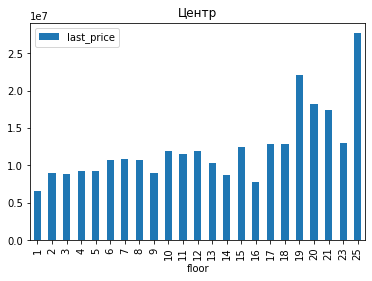

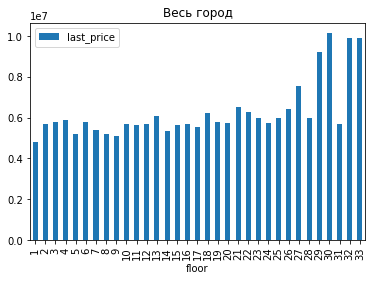

In [252]:
real_estate_central.pivot_table(index='floor', values='last_price', aggfunc='median').plot.bar(title='Центр')
real_estate_spb.pivot_table(index='floor', values='last_price', aggfunc='median').plot.bar(title='Весь город')

В целом, влияние этажей на цену квартиры во всем городе остается таким же, как и в центре.

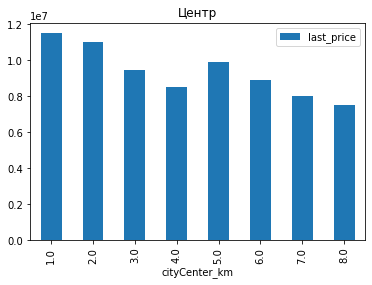

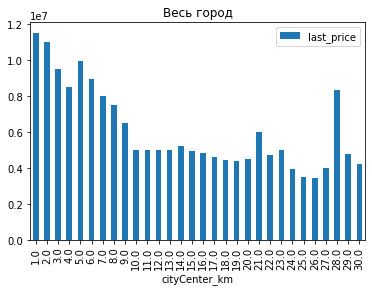

In [253]:
real_estate_central.pivot_table(index='cityCenter_km', values='last_price', aggfunc='median').plot.bar(title='Центр')
real_estate_spb.pivot_table(index='cityCenter_km', values='last_price', aggfunc='median').plot.bar(title='Весь город')

Удаленность от центра во всем городе (начиная с 8 км) не сильно влияет на стоимость квартиры. Но цена повышается сразу, как только квартира находится на расстоянии 8 км и ближе к центру.

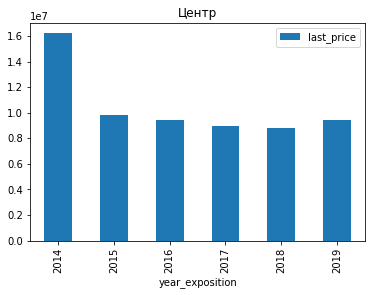

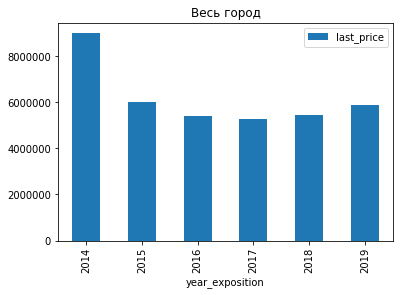

In [254]:
real_estate_central.pivot_table(index='year_exposition', values='last_price', aggfunc='median').plot.bar(title='Центр')
real_estate_spb.pivot_table(index='year_exposition', values='last_price', aggfunc='median').plot.bar(title='Весь город')

Здесь наблюдаем такую же тендцению, что и в центре, квартиры были дорогими в 2014 году, а потом стали дешевле и особо не менялись в цене.

## Общий вывод

Изначально наши данные имели достаточно большое количество пропусков, большинство из них пришлось оставить, ведь они имели смысл, какие-то пришлось заполнить, от каких-то объявлений пришлось избавиться. До предобработки в наших данных было 23699 объявлений, а после предобработки осталось 22461.

In [255]:
print('Средняя стоимость квадратного метра: {:.0f}'.format(real_estate_ads['price_per_square_meter'].mean()))
total_area_living_area = real_estate_ads['living_area'] / real_estate_ads['total_area']
print('Медиана доли жилой площади относительно общей площади: {:.2%}'.format(total_area_living_area.median()))

total_area_kitchen_area = real_estate_ads['kitchen_area'] / real_estate_ads['total_area']
print('Медиана доли площади кухни относительно общей площади: {:.2%}'.format(total_area_kitchen_area.median()))

Средняя стоимость квадратного метра: 99189
Медиана доли жилой площади относительно общей площади: 57.01%
Медиана доли площади кухни относительно общей площади: 17.10%


In [256]:
print('Топ 10 населенных пунктов по количеству объявлений: {}'.format(top_10_locality))

Топ 10 населенных пунктов по количеству объявлений:                    count
locality_name           
Санкт-Петербург    15027
посёлок Мурино       490
посёлок Шушары       423
Всеволожск           385
Пушкин               348
Колпино              329
посёлок Парголово    305
Гатчина              299
деревня Кудрово      277
Выборг               228


In [257]:
print('Медиана времени продажи квартиры: {:.2f}'.format(real_estate_ads['days_exposition'].median()))
print('Среднее время продажи квартиры: {:.2f}'.format(real_estate_ads['days_exposition'].mean()))

Медиана времени продажи квартиры: 96.00
Среднее время продажи квартиры: 169.86


Цена за квадратный метр относительно населенного пункта:

In [258]:
real_estate_ads.query('locality_name in @top_10_locality.index').pivot_table(
    index='locality_name', values='price_per_square_meter').sort_values(by='price_per_square_meter', ascending=False)

,price_per_square_meter
locality_name,
Санкт-Петербург,113677.516181
Пушкин,102577.467363
деревня Кудрово,92469.304898
посёлок Парголово,89617.762289
посёлок Мурино,85558.193538
посёлок Шушары,78397.229739
Колпино,75297.303846
Гатчина,68902.681515
Всеволожск,68766.572031


In [259]:
print('Средняя удаленность квартир от центра: {:.0f} км'.format(real_estate_ads['cityCenter_km'].mean()))

Средняя удаленность квартир от центра: 15 км


Наиболее влияющие факторы на стоимость квартиры:

- Общая площадь
- Удаленность от центра
- Количество комнат
- Этаж (первый, другой, последний)


Год, в котором цена на квартиры была самой большой: 2014 год